## Cointegración - Ejemplo ETFs

Cargamos los datos para 3 ETF.

EWA - ETF iShares MSCI Australia busca replicar los resultados de inversión de un índice compuesto por valores de renta variable de Australia.

EWC - ETF iShares MSCI Canadá busca replicar los resultados de inversión de un índice compuesto por valores de renta variable de Canadá.

IGE - ETF iShares North American Natural Resources ETF busca replicar los resultados de inversión de un índice compuesto por valores de renta variable de Norte América en el sector de recursos naturales.

La motivación económica supone que las economías australiana y canadiense tienen altas participaciones ligadas al sector de recursos natuales.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as jn
from scipy.io import loadmat

tickers = ['EWC', 'EWA', 'IGE']
mat = loadmat('..\inputData_ETF.mat')
idx = {a[0]:i for i, a in enumerate(mat['syms'][0]) if a[0] in tickers}
data = pd.DataFrame(mat['cl'][:, list(idx.values())], columns=list(idx.keys()))
EWA = pd.DataFrame(mat['cl'][:, 10])
EWC = pd.DataFrame(mat['cl'][:, 11])
IGE = pd.DataFrame(mat['cl'][:, 26])

Data = pd.concat([EWA, EWC, IGE], axis=1, join='inner').values


Recordemos que el concepto de cointegración se refiere a la existencia de una relación lineal estable en el largo plazo entre 2 o más series no estacionarias.
Esto hace que 2 o más series que no tienen por si solas posibilidades de tener comportamientos que puedan ser explorados para definir una estrategia de trading. Es decir, sus momentos no están bien definidor y constantes. Al combinarlas, si podremos definir una serie estacionaria y por tanto saber que esa serie tiene una valor esperado al que se espera retorne y por tanto no divege sistematicamente creando oportunidades de trading siempre que encontramos un nivel de divergencia que sabemos no se va a sostener en el tiempo.

Para encontar esa combinación lineal usamos el Test de Cointegración de Johansen.

In [8]:
#Johansen Test
res = jn.coint_johansen(Data, 0, 1)
rel_coint = Data * res.evec[:, 0]  # If Data are prices, we get a portfolio value. Select eigenvector with higher eigenvalue.
Data = np.insert(Data, Data.shape[1], rel_coint.sum(axis=1), axis=1)


---Autovalores---
[0.01121626 0.00868086 0.00298021]

---Autovectores---
[[ 0.7599635  -0.11204898  0.0789828 ]
 [-1.04602749 -0.5796762   0.26467204]
 [ 0.22330592  0.53159644 -0.09515547]]


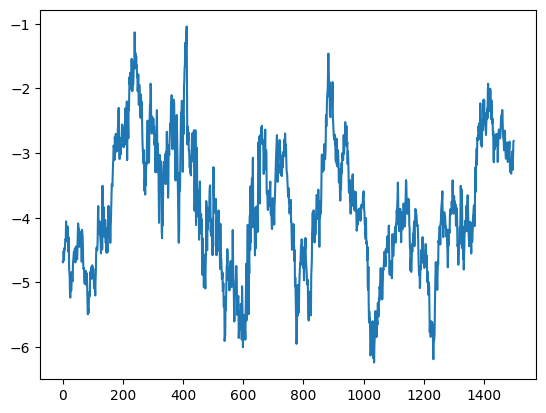

In [27]:
print('---Autovalores---')
print(res.eig.__str__() + '\n')
print('---Autovectores---')
print(res.evec)
plt.plot(rel_coint.sum(axis=1))

Notemos que por cada variable tenemos una relación de cointegración. Tomamos la de mayor autovalor (ver biblio).
En el gráfico vemos la serie cointegrada. Es decir, el producto matricial de los precios de los ETFs por el vector de cointegración elegido. Podemos chequear que esta seri sí es estacionaria (pueden hacer un test ADF para corroborar).

In [45]:
import statsmodels.tsa.stattools as st
import numpy as np
adf = st.adfuller(rel_coint.sum(axis=1),regresults=True)
hl = -np.log(2)/adf[-1].autolag_results[2].params[1]
print('Half-Life  ' + hl.__str__())

Half-Life  22.399140543666284


Ahora bien. Tenemos esta relación que nos sirve para evaluar cuando la serie se está alejando demasiado de su valor de equilibrio.
Sin embargo, tenemos más herramientas a disposición. Existe el concepto de mitad de vida o Half-Life para una serie que revierte a la media. Este concepto nos dice cuanto tiempo tarda en promedio el proceso para volver a ser atraido por su media.
El siguiente paso es usar ese valor para hace una media movil de la serie cointegrada. Es razonable pensar qeu si no serie tarda uno 22 o 23 periodos en "converger", tomar decisiones sobre alguna medida de tendencia que contenga esa cantidad de períodos. Es decir, nos intresa la historia se la serie (en este caso por lo que tarda en promedio para converger) para poder decidir si esta más cerca o mas lejos de la media.

<AxesSubplot:title={'center':'Standard coint relation'}, xlabel='Time', ylabel='Std_relation'>

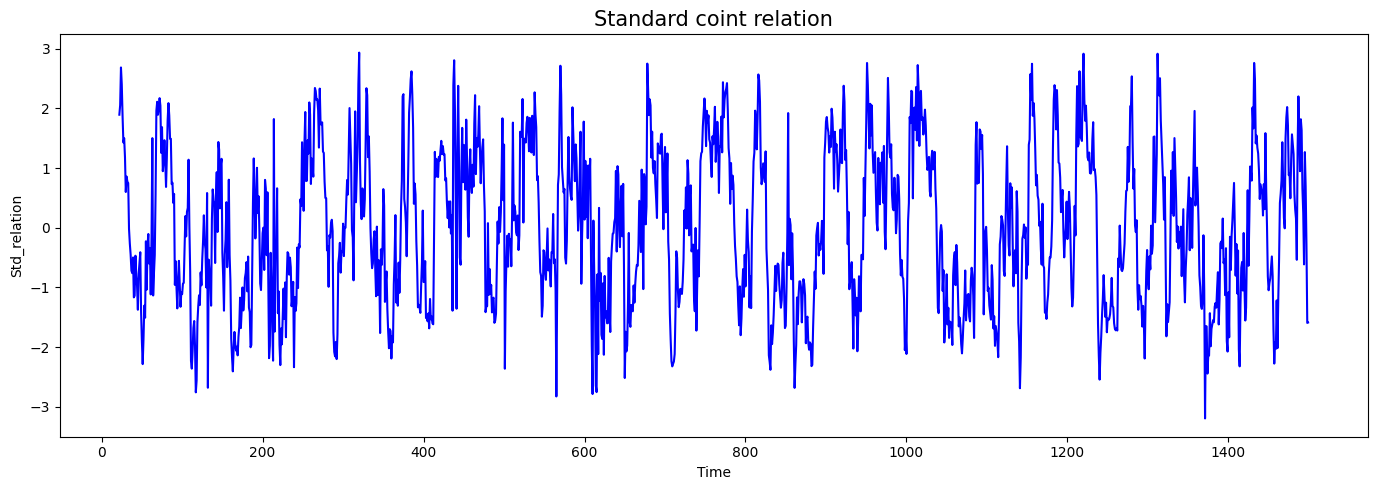

In [47]:
# region From cointegrated portfolio value to standarized portfolio
lookback = 23
std_units = 1
coint_relation = pd.DataFrame(Data[:, Data.shape[1] - 1], columns={'Coint_relation'})  # portfolio value
coint_relation['RMean'] = coint_relation['Coint_relation'].rolling(lookback).mean()
coint_relation['RStd'] = coint_relation['Coint_relation'].rolling(lookback).std()
coint_relation['Std_relation'] = - (coint_relation['Coint_relation'].values - coint_relation['RMean'].values)\
                                 / (std_units * coint_relation['RStd'].values)  # std desv units
# endregion


# region Plot standarized relation
plt.ion()
fig, ax = plt.subplots(figsize=(14, 5))
plt.title('Standard coint relation', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Std_relation')
plt.tight_layout()
coint_relation['Std_relation'].plot(kind='line', y='Bid', lw=1.5, color='b', label='Std_relation', ax=ax)
#plt.plot(coint_relation['Std_relation'])
# endregion



En este caso a esta nueva serie suavizada, la normalizamos dado que no nos interessan los niveles de la relación de cointegración solo la vamos a usar para generar señales de comrpa-venta.

Con esta seris estandarizada calculamos la cantidad de ETFs que debe tener nuestra cartera para nuestro portfolio estandarizado.

In [48]:

portfolio_units = np.multiply(np.tile(coint_relation['Std_relation'].values, (3, 1)).transpose(),
                              np.tile(res.evec[:, 0], (1500, 1)))  # in std desv unit. More units of std desv far from mean, more exposition to get higher profit.
print(portfolio_units)

[[        nan         nan         nan]
 [        nan         nan         nan]
 [        nan         nan         nan]
 ...
 [-0.21076268  0.29009756 -0.06193002]
 [-1.21182137  1.66797282 -0.3560788 ]
 [-1.20727087  1.66170944 -0.35474169]]


Notar que cuanto más distante esta el valor observado de la serie de cointegracion, de su media (de 23 periodos), y mas pequeña es la desv estandar. La serie estandarizada (que son unidades de desv estandar) toma valores mayores, y a mayor valor, mayor exposición o posición en el portfolio. Esto no tiene que ser así, podriamos solo generar la señal de venta o compra. Sin embargo, en este caso razonamos lo siguiente. Cuando más lejos de la media estoy tomo mas exposición porque cuando revierta voy a tener más recorrido ganador.
Calculamos el valor del portfolio o valor de nuestra posición (-vendido en el portfolio (estamos mas short), + comprado(estamos m+as long))

In [64]:

positions = np.multiply(portfolio_units
                        , Data[:, [0, 1, 2]])  # Units x prices to get value positions

print(positions.sum(axis=1)[-10:])

[-6.02472173 -5.41979431 -2.05828963 -0.76748507  1.82782221 -4.13227326
 -2.21160253  0.84190432  4.50742627  4.46763576]


Veamos el retorno acumulado de la estrategia:

<AxesSubplot:>

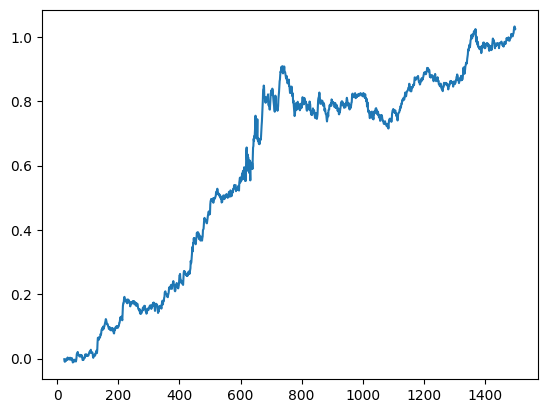

In [67]:
prices_df = pd.DataFrame(Data[:, [0, 1, 2]])
pnl = (prices_df.pct_change() * pd.DataFrame(positions).shift(1)).sum(axis=1)
returns = pnl.divide(pd.DataFrame(np.abs(positions)).shift(1).sum(axis=1))  # Take abs to get total exposure

((returns + 1).cumprod(skipna=True) - 1).plot(label='Cum Return')  # cum return



In [69]:
print(((returns + 1).cumprod(skipna=True) - 1))


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1495    1.023925
1496    1.026740
1497    1.032052
1498    1.024368
1499    1.023840
Length: 1500, dtype: float64


El retorno acumulado al final del período 102.384 %